<a href="https://colab.research.google.com/github/GuilhermeLopesBertacini/emotion-recognition-model/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [ ]:
from typing import Tuple, List
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset

In [ ]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
TRAIN_DIR = '/kaggle/input/fer2013/train/'
TEST_DIR = '/kaggle/input/fer2013/test/'

In [ ]:
def load_data(data_dir: str) -> Tuple[List[str], List[str]]:
    """
    Load image paths and their corresponding labels from a directory structure.

    Args:
        data_dir (str): The absolute path to the data directory
                        (e.g., train_dir, test_dir). Each subdirectory should be a label.

    Returns:
        Tuple[List[str], List[str]]: A tuple containing:
            - A list of full image file paths.
            - A list of corresponding labels.
    """
    image_paths = []
    labels = []

    for label in sorted(os.listdir(data_dir)):
        label_dir = os.path.join(data_dir, label)

        for image_name in sorted(os.listdir(label_dir)):
            image_path = os.path.join(label_dir, image_name)

            image_paths.append(image_path)
            labels.append(label)
        print(f"{label} completed")
    return image_paths, labels

In [ ]:
# Convert into df
train = pd.DataFrame()
train['image'], train['label'] = load_data(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,/kaggle/input/fer2013/train/angry/Training_858...,angry
1,/kaggle/input/fer2013/train/sad/Training_73530...,sad
2,/kaggle/input/fer2013/train/happy/Training_273...,happy
3,/kaggle/input/fer2013/train/neutral/Training_8...,neutral
4,/kaggle/input/fer2013/train/happy/Training_469...,happy


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_data(TEST_DIR)
test.head()

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


,image,label
0,/kaggle/input/fer2013/test/angry/PrivateTest_1...,angry
1,/kaggle/input/fer2013/test/angry/PrivateTest_1...,angry
2,/kaggle/input/fer2013/test/angry/PrivateTest_1...,angry
3,/kaggle/input/fer2013/test/angry/PrivateTest_1...,angry
4,/kaggle/input/fer2013/test/angry/PrivateTest_1...,angry


# Data Analysis


Text(0.5, 1.0, 'Label Distribution')

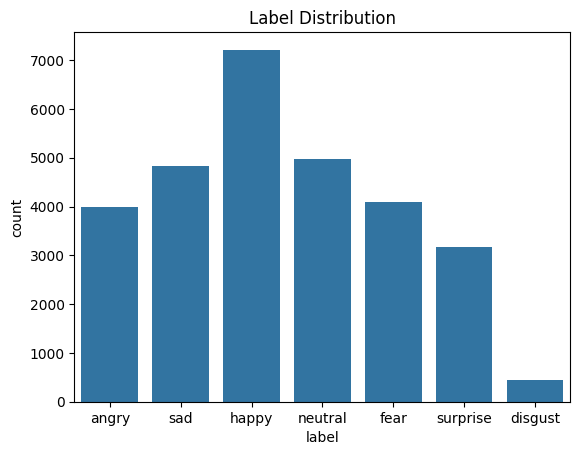

In [ ]:
sns.countplot(x=train['label'])
plt.title("Label Distribution")

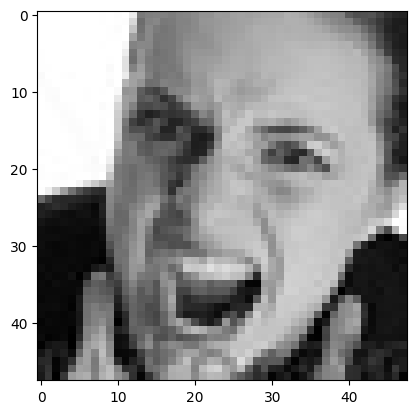

In [ ]:
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')

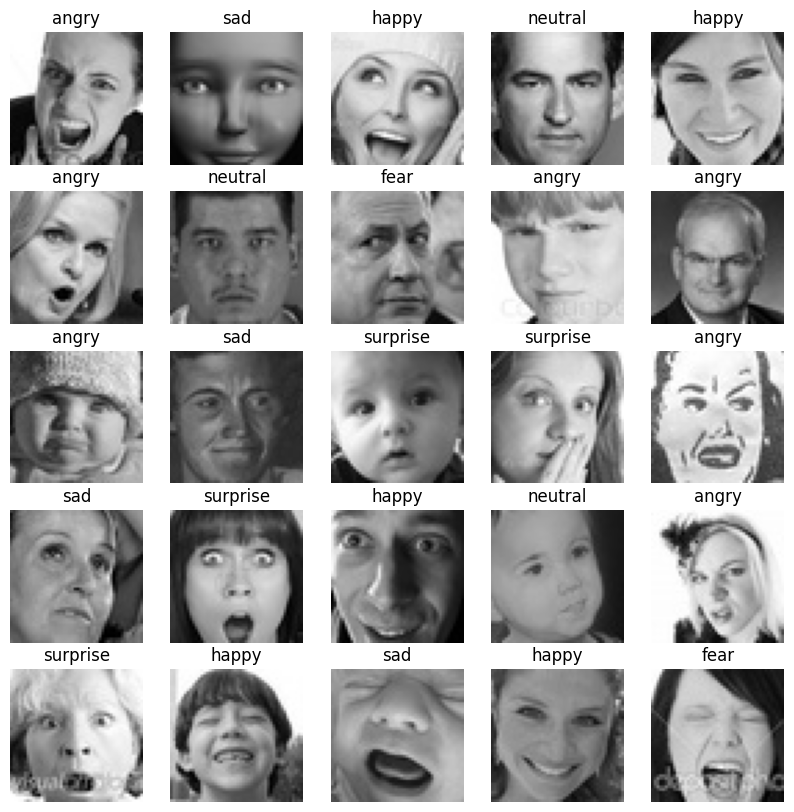

In [ ]:
# Display grid of images
plt.figure(figsize=(10, 10))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img, cmap='gray')
  plt.title(label)
  plt.axis('off')

# Feature Extraction

In [ ]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale', target_size=(48, 48))
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  return features # shape (N, 48, 48, 1)

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
print(train_features[0][0])

[255 255 255 255 255 255 255 255 254 255 253 255 237 122 127 129 129 125
 131 133 139 148 148 155 154 160 162 160 163 167 168 168 176 174 169 159
 147 136 131 129  92  80  82  84  67  48  38  35]


In [ ]:
## Normalize images
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## Convert labels to integers
le = LabelEncoder()
le.fit(train['label'])

y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# config
num_classes = len(os.listdir(TRAIN_DIR))

In [ ]:
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
y_train[0]
# The index corresponds to the classes

array([1., 0., 0., 0., 0., 0., 0.])

# model's architecture.

### Convolutional Layers (Conv2D)
These layers act as **feature detectors**, using learnable filters to find patterns like edges and textures. Deeper layers combine these to recognize more complex objects.

---

### Activation Function (ReLU)
ReLU ($f(x) = \max(0, x)$) introduces crucial **non-linearity**. It's computationally fast and helps prevent the **vanishing gradient problem**, enabling effective training of deep networks.

---

### Pooling Layers (MaxPooling & GlobalAveragePooling)
**Max Pooling** downsamples feature maps, making the learned features more robust to small shifts and reducing computation. **Global Average Pooling** converts the final feature maps into a single vector for classification, significantly reducing parameters and helping to prevent overfitting.

---

### Dropout
This is a regularization technique to **prevent overfitting**. It randomly ignores a fraction of neurons during training, forcing the network to learn more robust features. The dropout rate is increased in later layers where overfitting is a greater risk.

---

### Batch Normalization
Applied after convolutions, this technique normalizes the activations. This leads to **faster, more stable training** and makes the network less sensitive to the initial weight configuration.

---

### Dense Layers
These fully connected layers act as the **classifier**. They take the high-level features extracted by the convolutional blocks and make a final prediction. The last layer uses a **softmax** activation to output a probability for each class.

In [ ]:
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), input_shape=(48, 48, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Block 2
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Block 3
    Conv2D(256, (3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Block 4
    Conv2D(512, (3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.2819 - loss: 1.7771 - val_accuracy: 0.3440 - val_loss: 1.6320
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.4061 - loss: 1.5361 - val_accuracy: 0.3860 - val_loss: 1.5913
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4407 - loss: 1.4457 - val_accuracy: 0.4595 - val_loss: 1.3909
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4573 - loss: 1.3908 - val_accuracy: 0.4836 - val_loss: 1.3284
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4799 - loss: 1.3460 - val_accuracy: 0.4869 - val_loss: 1.3195
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5032 - loss: 1.3012 - val_accuracy: 0.4929 - val_loss: 1.2993
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5121 - loss: 1.2662 - val_accuracy: 0.5099 - val_loss: 1.2567
Epoch 8/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5223 - loss: 1

### Plot Results

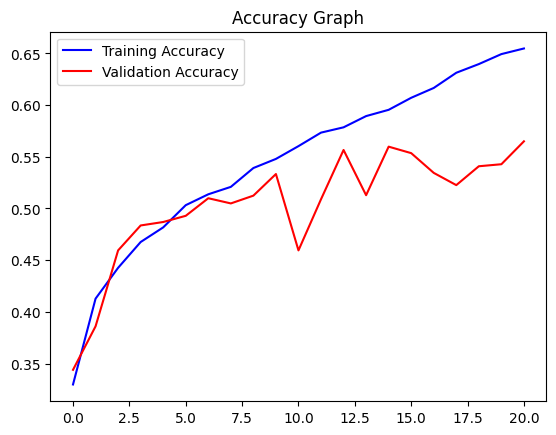

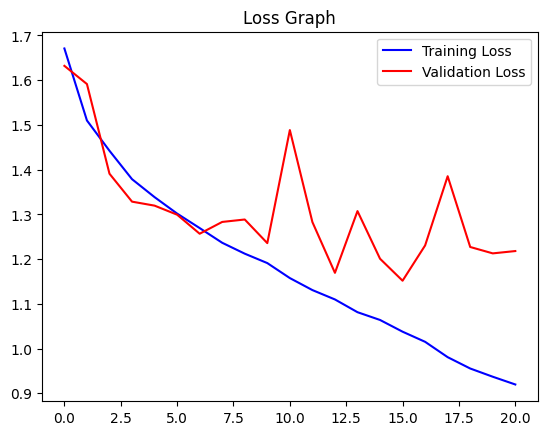

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

### Save Model

In [ ]:
from google.colab import files
model.save("emotion_recognition_model.h5")
files.download("emotion_recognition_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>